In [10]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import s3fs
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import matplotlib.path as mpath
from read_pangeo import read_pangeo, read_to_detect
from importcmip import aod245, aodh, aod585, read_370

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
#load and merge data
arh = xr.open_dataset('historical20002014_AR_detection.nc')
ar245 = xr.open_dataset('ssp24520852100_AR_detection.nc')
ar370 = xr.open_dataset('ssp37020852099_AR_detection.nc')
ar585 = xr.open_dataset('ssp58520852100_AR_detection.nc')

cmh = read_pangeo(2000, 2014, 'historical')
dh = cmh.merge(aodh.drop(('lat_bnds', 'time_bnds', 'lon_bnds')))

cm245 = read_pangeo(2085, 2099, 'ssp245')
d245= cm245.merge(aod245.drop(('lat_bnds', 'time_bnds', 'lon_bnds')))

cm370 = read_pangeo(2085, 2099, 'ssp370')
cm370b = read_370()
d370 = cm370.merge(cm370b.drop(('lat_bnds', 'time_bnds', 'lon_bnds')))


cm585 = read_pangeo(2085, 2099, 'ssp585')
d585 = cm585.merge(aod585.drop(('lat_bnds', 'time_bnds', 'lon_bnds')))




--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [13]:
# slice to poles and only until pressure levels where AR can be detected
n245 = d245.sel(lat = slice(50,90),plev=slice(100000, 25000))
s245 =d245.sel(lat = slice(-90,-50),plev=slice(100000, 25000))

n370 = d370.sel(lat = slice(50,90),plev=slice(100000, 25000))
s370 =d370.sel(lat = slice(-90,-50),plev=slice(100000, 25000))

n585 = d585.sel(lat = slice(50,90),plev=slice(100000, 25000))
s585 =d585.sel(lat = slice(-90,-50),plev=slice(100000, 25000))

nh = dh.sel(lat = slice(50,90), plev=slice(100000, 25000))
sh =dh.sel(lat = slice(-90,-50), plev=slice(100000, 25000))


# mask data for being inside or outside of a atmospheric river
# arctic
masked_n245 = n245.where(ar245['ivt']==True)
masked_n370 = n370.where(ar370['ivt']==True)
masked_n585 = n585.where(ar585['ivt']==True)
masked_nh = nh.where(arh['ivt']==True)

neg_n245 = n245.where(ar245['ivt']==False)
neg_n370 = n370.where(ar370['ivt']==False)
neg_n585 = n585.where(ar585['ivt']==False)
neg_nh = nh.where(arh['ivt']==False)

# antarctic
masked_s245 = s245.where(ar245['ivt']==True)
masked_s370 = s370.where(ar370['ivt']==True)
masked_s585 = s585.where(ar585['ivt']==True)
masked_sh = sh.where(arh['ivt']==True)

neg_s245 = s245.where(ar245['ivt']==False)
neg_s370 = s370.where(ar370['ivt']==False)
neg_s585 = s585.where(ar585['ivt']==False)
neg_sh = sh.where(arh['ivt']==False)

In [14]:
#treat variables for plotting
#integrate needed humidity
int_nh245 =-1*masked_n245['hus'].integrate('plev')
int_sh245 =-1*masked_s245['hus'].integrate('plev')
int_nh370 =-1*masked_n370['hus'].integrate('plev')
int_sh370 =-1*masked_s370['hus'].integrate('plev')
int_nh585 =-1*masked_n585['hus'].integrate('plev')
int_sh585 =-1*masked_s585['hus'].integrate('plev')
int_nhh =-1*masked_nh['hus'].integrate('plev')
int_shh =-1*masked_sh['hus'].integrate('plev')

# for plotting with matplotlib: flatten db to array 
int_nh245 = int_nh245.values.flatten() 
int_sh245 = int_sh245.values.flatten()
int_nh370 = int_nh370.values.flatten()
int_sh370 = int_sh370.values.flatten()
int_nh585 = int_nh585.values.flatten()
int_sh585 = int_sh585.values.flatten()
int_nhh = int_nhh.values.flatten()
int_shh = int_shh.values.flatten()


NameError: name 'mh' is not defined

In [15]:

# remove na from dataset to be able to weight distribution
int_nh245 = int_nh245[~np.isnan(int_nh245)]
int_sh245 = int_sh245[~np.isnan(int_sh245)]
int_nh370 = int_nh370[~np.isnan(int_nh370)]
int_sh370 = int_sh370[~np.isnan(int_sh370)]
int_nh585 = int_nh585[~np.isnan(int_nh585)]
int_sh585 = int_sh585[~np.isnan(int_sh585)]
int_nhh = int_nhh[~np.isnan(int_nhh)]
int_shh = int_shh[~np.isnan(int_shh)]


In [30]:
#treat variables for plotting
# AOD
# for plotting with matplotlib: flatten db to array 
na245 = masked_n245['od550aer'].values.flatten() 
sa245 = masked_s245['od550aer'].values.flatten()
na370 = masked_n370['od550aer'].values.flatten()
sa370 = masked_s370['od550aer'].values.flatten()
na585 = masked_n585['od550aer'].values.flatten()
sa585 = masked_s585['od550aer'].values.flatten()
nah = masked_nh['od550aer'].values.flatten()
sah = masked_sh['od550aer'].values.flatten()

# remove na from dataset to be able to weight distribution
na245 = na245[~np.isnan(na245)]
sa245 = sa245[~np.isnan(sa245)]
na370 = na370[~np.isnan(na370)]
sa370 = sa370[~np.isnan(sa370)]
na585 = na585[~np.isnan(na585)]
sa585 = sa585[~np.isnan(sa585)]
nah = nah[~np.isnan(nah)]
sah = sah[~np.isnan(sah)]

NameError: name 'mh' is not defined

ValueError: Dimensions {'tas', 'hus', 'od550aer', 'va', 'pr', 'clt'} do not exist. Expected one or more of Frozen({'lat': 22, 'lon': 144, 'time': 5475})

In [44]:
#treat variables for plotting
# precipitation
# for plotting with matplotlib: flatten db to array 
np245 = masked_n245['pr'].values.flatten() 
#sp245 = masked_s245['pr'].values.flatten()
np370 = masked_n370['pr'].values.flatten()
#sp370 = masked_s370['pr'].values.flatten()
np585 = masked_n585['pr'].values.flatten()
#sp585 = masked_s585['pr'].values.flatten()
nph = masked_nh['pr'].values.flatten()
#sph = masked_sh['pr'].values.flatten()

# remove na from dataset to be able to weight distribution
np245 = np245[~np.isnan(np245)]
#sp245 = sp245[~np.isnan(sp245)]
np370 = np370[~np.isnan(np370)]
#sp370 = sp370[~np.isnan(sp370)]
np585 = np585[~np.isnan(np585)]
#sp585 = sp585[~np.isnan(sp585)]
nph = nph[~np.isnan(nph)]
#sph = sph[~np.isnan(sph)]

In [42]:
'''
#axs = axs.flatten()
#fig.suptitle('', fontsize=16)

def freq_hist(var_name, var245, var370, var585, varhist):

fig, axs = plt.subplots(figsize=(10,6))
fig.suptitle(str(var_name), fontsize=16)

axs.hist(var245, weights = np.zeros_like(var245)+1./var245.size, 
       alpha = 0.5, color = "g", label = "ssp245", bins=30)
axs.hist(var370, weights = np.zeros_like(var370)+1./var370.size, 
       alpha = 0.3, color = "b", label = "ssp370", bins=30)
axs.hist(var585, weights = np.zeros_like(var585)+1./var585.size, 
          alpha = 0.5, color = "y", label = "ssp585", bins=30)
axs.hist(varhist, weights = np.zeros_like(varhist)+1./int_nhh.size, 
       alpha = 0.2, color = "k", label = "historical", bins=30)
axs.label()
    
'''

'\n#axs = axs.flatten()\n#fig.suptitle(\'\', fontsize=16)\n\ndef freq_hist(var_name, var245, var370, var585, varhist):\n\nfig, axs = plt.subplots(figsize=(10,6))\nfig.suptitle(str(var_name), fontsize=16)\n\naxs.hist(var245, weights = np.zeros_like(var245)+1./var245.size, \n       alpha = 0.5, color = "g", label = "ssp245", bins=30)\naxs.hist(var370, weights = np.zeros_like(var370)+1./var370.size, \n       alpha = 0.3, color = "b", label = "ssp370", bins=30)\naxs.hist(var585, weights = np.zeros_like(var585)+1./var585.size, \n          alpha = 0.5, color = "y", label = "ssp585", bins=30)\naxs.hist(varhist, weights = np.zeros_like(varhist)+1./int_nhh.size, \n       alpha = 0.2, color = "k", label = "historical", bins=30)\naxs.label()\n    \n'

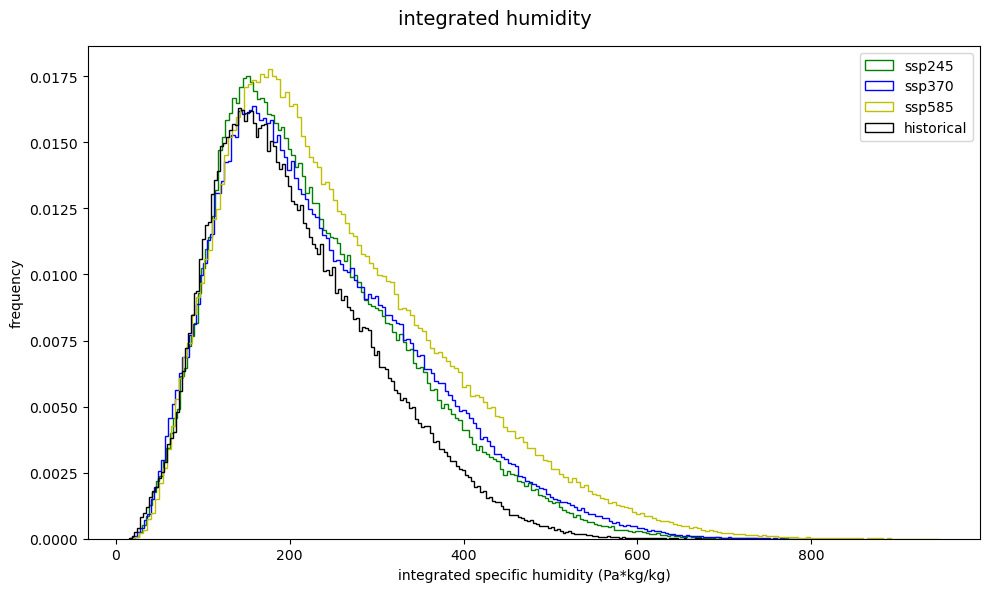

In [28]:
fig, axs = plt.subplots(figsize=(10,6))
fig.suptitle('integrated humidity', fontsize=14)

axs.hist(int_nh245, weights = np.zeros_like(int_nh245)+1./int_nh245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins= 200)
axs.hist(int_nh370, weights = np.zeros_like(int_nh370)+1./int_nh370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins= 200)
axs.hist(int_nh585, weights = np.zeros_like(int_nh585)+1./int_nh585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins= 200)
axs.hist(int_nhh, weights = np.zeros_like(int_nhh)+1./int_nhh.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins= 200)
axs.legend() 
axs.set( xlabel = 'integrated specific humidity (Pa*kg/kg)', ylabel = 'frequency')
plt.tight_layout()

ZeroDivisionError: float division by zero

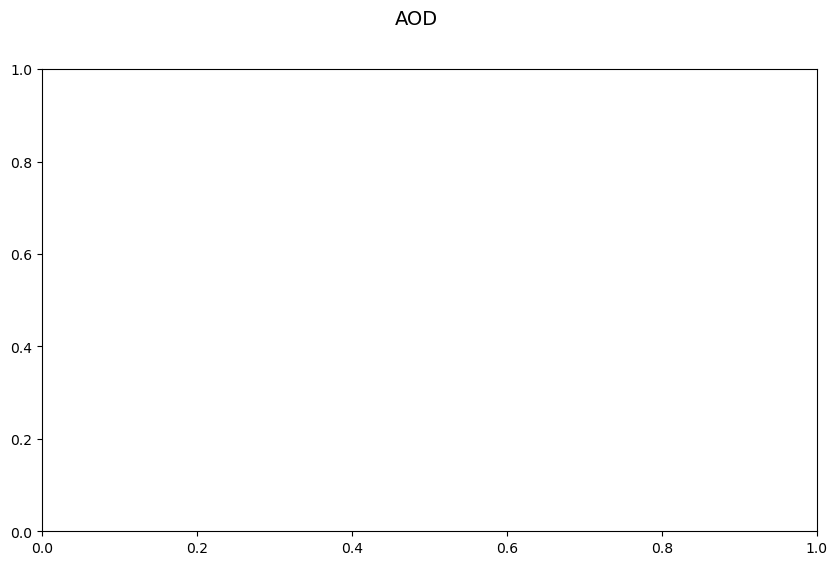

In [32]:
fig, axs = plt.subplots(figsize=(10,6))
fig.suptitle('AOD', fontsize=14)

axs.hist(na245, weights = np.zeros_like(na245)+1./na245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins= 200)
axs.hist(na370, weights = np.zeros_like(na370)+1./na370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins= 200)
axs.hist(na585, weights = np.zeros_like(na585)+1./na585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins= 200)
axs.hist(nah, weights = np.zeros_like(nah)+1./nah.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins= 200)
axs.legend() 
axs.set( xlabel = 'AODat 500 nm (1)', ylabel = 'frequency')
plt.tight_layout()

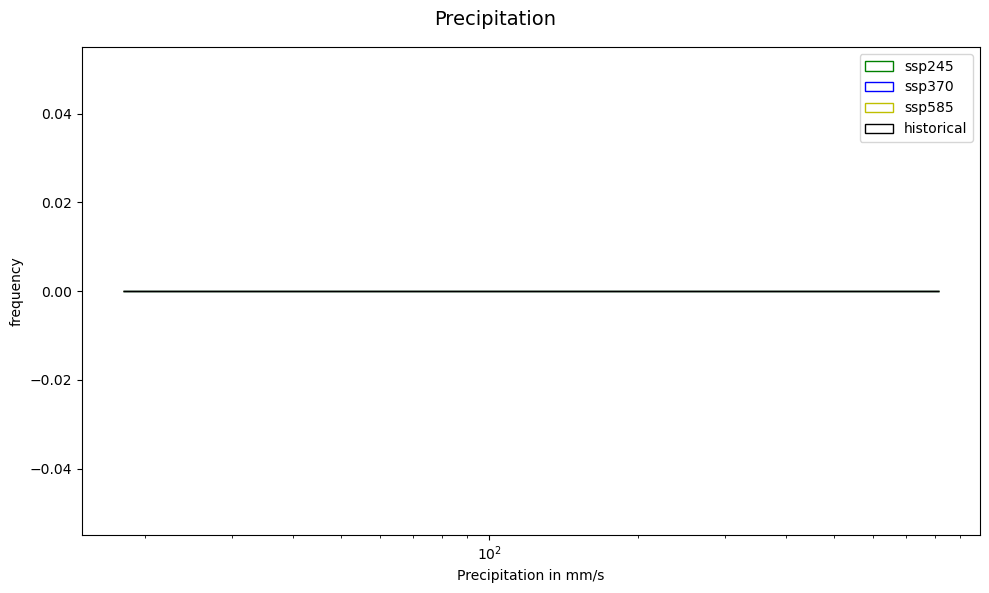

In [48]:
fig, axs = plt.subplots(figsize=(10,6))
fig.suptitle('Precipitation', fontsize=14)

axs.hist(np245, weights = np.zeros_like(np245)+1./np245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins=np.logspace(np.log10(int_nh245.min()),np.log10(int_nh245.max()),20))
axs.hist(np370, weights = np.zeros_like(np370)+1./np370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins=np.logspace(np.log10(int_nh245.min()),np.log10(int_nh245.max()),20))
axs.hist(np585, weights = np.zeros_like(np585)+1./np585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins=np.logspace(np.log10(int_nh245.min()),np.log10(int_nh245.max()),20))
axs.hist(nph, weights = np.zeros_like(nph)+1./nph.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins=np.logspace(np.log10(int_nh245.min()),np.log10(int_nh245.max()),20))
axs.legend() 
axs.set( xscale = 'log', xlabel = 'Precipitation in mm/s', ylabel = 'frequency')
plt.tight_layout()

[None, Text(0.5, 0, 'integrated specific humidity'), Text(0, 0.5, 'frequency')]

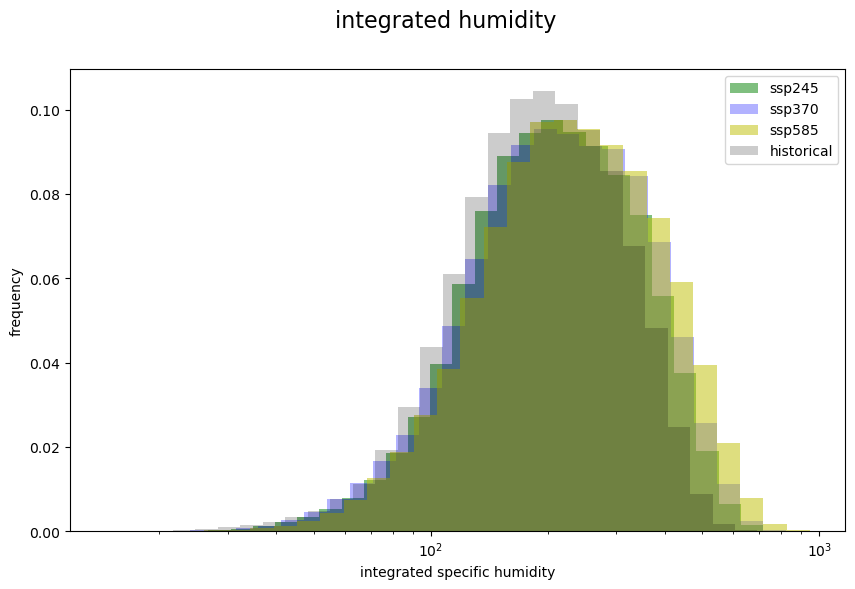

In [19]:
fig, axs = plt.subplots(figsize=(10,6))
fig.suptitle('integrated humidity', fontsize=16)

axs.hist(int_nh245, weights = np.zeros_like(int_nh245)+1./int_nh245.size, 
       alpha = 0.5, color = "g", label = "ssp245", bins=np.logspace(np.log10(int_nh245.min()),np.log10(int_nh245.max()),30))
axs.hist(int_nh370, weights = np.zeros_like(int_nh370)+1./int_nh370.size, 
       alpha = 0.3, color = "b", label = "ssp370", bins=np.logspace(np.log10(int_nh370.min()),np.log10(int_nh370.max()),30))
axs.hist(int_nh585, weights = np.zeros_like(int_nh585)+1./int_nh585.size, 
          alpha = 0.5, color = "y", label = "ssp585", bins=np.logspace(np.log10(int_nh585.min()),np.log10(int_nh585.max()),30))
axs.hist(int_nhh, weights = np.zeros_like(int_nhh)+1./int_nhh.size, 
       alpha = 0.2, color = "k", label = "historical", bins=np.logspace(np.log10(int_nhh.min()),np.log10(int_nhh.max()),30))
axs.legend() 
axs.set(xscale = 'log',  xlabel = 'integrated specific humidity (Pa*kg/kg)', ylabel = 'frequency')

In [ ]:
'''# for frequency plots slice for plev >25000 and integrate over plev
mpl =marc.sel(plev=slice(100000, 25000))
pl =amarc.sel(plev=slice(100000, 25000)).where(arc['va'] > 0)

# wind
mplva =-1*mpl['va'].integrate('plev')
plva =-1*pl['va'].integrate('plev')

# humidity
mplh =-1*mpl['hus'].integrate('plev')
plh =-1*pl['hus'].integrate('plev')

mv = mplva.values.flatten()
mv = mv[~np.isnan(mv)]
v = plva.values.flatten()
v= v[~np.isnan(v)]
mh = mplh.values.flatten()
mh = mh[~np.isnan(mh)]
h = plh.values.flatten()
h = h[~np.isnan(h)]
mcc = pl['clt'].values.flatten()
mcc = mcc[~np.isnan(mcc)]
cc = mpl['clt'].values.flatten()
cc = cc[~np.isnan(cc)]
mt = mpl['tas'].values.flatten()
mt = mt[~np.isnan(mt)]
t = pl['tas'].values.flatten()
t = t[~np.isnan(t)]
ma = mpl['od550aer'].values.flatten()
ma = ma[~np.isnan(ma)]
a = pl['od550aer'].values.flatten()
a = a[~np.isnan(a)]
mp = mpl['pr'].values.flatten()
mp = mp[~np.isnan(mp)]
mp = mp[mp>0.0000024099]
p = pl['pr'].values.flatten()
p = p[~np.isnan(p)]
p = p[p>0.0000024099] # threshold for averaged precipitation in the sahara in the same unit'''